In [19]:
%matplotlib inline
#from utils import *
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from time import time
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
import umap

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.43 ms, sys: 147 ms, total: 148 ms
Wall time: 146 ms
CPU times: user 705 µs, sys: 12.7 ms, total: 13.4 ms
Wall time: 13.2 ms
CPU times: user 878 µs, sys: 69.9 ms, total: 70.8 ms
Wall time: 70.6 ms
CPU times: user 941 µs, sys: 34.9 ms, total: 35.9 ms
Wall time: 35.7 ms
CPU times: user 707 µs, sys: 4.3 ms, total: 5 ms
Wall time: 4.73 ms
CPU times: user 724 µs, sys: 5.97 ms, total: 6.7 ms
Wall time: 6.43 ms
CPU times: user 750 µs, sys: 22.2 ms, total: 22.9 ms
Wall time: 22.7 ms


# Load 6x24 MIR features

In [3]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    print(drum_features.shape)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)
x_data_MIR.shape: (10560, 6, 24)
x_data_MIR.shape: (10560, 144)


# Load 32x32 STFT features

In [4]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
#drumNames = pickle.load(open(data_root+'drumNames.pickle'))
#drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

x_data_STFT.shape: (10560, 32, 32)
x_data_STFT.shape: (10560, 1024)


# Load MFCC features

In [5]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

x_data_MFCC.shape: (10560, 30, 24)
x_data_MFCC.shape: (10560, 720)


# Load Wavenet features 23x16

In [6]:
x_data_Wavenet = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_wavenet.npy'
    drum_features = np.load(file_path)
    x_data_Wavenet.extend(drum_features)
x_data_Wavenet = np.asarray(x_data_Wavenet)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)
x_data_Wavenet = x_data_Wavenet.reshape(len(x_data_Wavenet),-1)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)

x_data_Wavenet.shape: (10560, 23, 16)
x_data_Wavenet.shape: (10560, 368)


# Create ground truth labels

y_data.shape: (10560,)


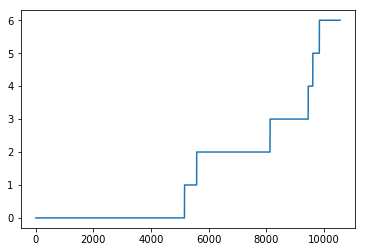

In [7]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Create ground truth color map

In [8]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    #print segmentList, colorList
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

In [16]:
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    #print("The average silhouette_score is :", silhouette_avg)
    return silhouette_avg

def plotSampleSilCoeff(data, cluster_labels, title):
    fig, ax1 = plt.subplots()
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    n_clusters = 7
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    #ax1.set_title("Av. Sil Coeff:", silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [37]:
def clusterGeometryMetrics(drum_points, labels):
    
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    roundness_np = np.asarray(roundness)
    roundness_mean = np.mean(roundness_np)
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
    #the polygons themselves for further processing 
    polygons = [drum_polygons.values()] + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['roundness_mean'] = roundness_mean
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

# Evaluating UMAP

In [10]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [11]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.data.shape)

embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(digits.data)

print(embedding.shape)

(1797, 64)
(1797, 2)


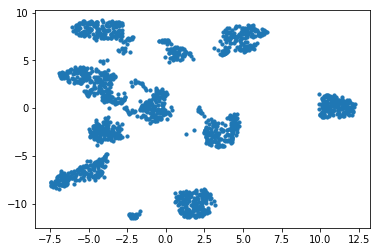

In [12]:
plt.scatter(embedding[:,0], 
                    embedding[:,1],
                    s=10)

In [19]:
import time
print(x_data_MIR.shape)
start_time = time.time()
embedding = umap.UMAP(n_neighbors=50,
                      min_dist=0.3,
                      metric='correlation').fit_transform(x_data_MIR)
print(embedding.shape)
print("time in secs: ", time.time() - start_time)

(10560, 144)
(10560, 2)
time in secs:  23.313962936401367


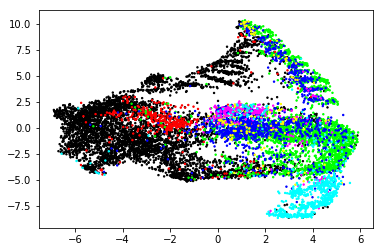

In [20]:
plt.scatter(embedding[:,0], 
                    embedding[:,1],
                    c=colorMap,
                    s=2)

In [25]:
import time
umap_embeddings = {}
umap_embeddings['mfccs'] = []
umap_embeddings['MIR'] = []
umap_embeddings['STFT'] = []
umap_embeddings['Wavenet'] = []

neighbours = [5, 10, 15, 30, 50]
distances = [0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        start_time = time.time()
        umap_MIR = get_scaled_umap_embeddings(x_data_MIR,neighbour,distance)
        
        #umap_embeddings['mfccs'].append(umap_mfccs)
        umap_embeddings['MIR'].append(umap_MIR)
        #umap_embeddings['STFT'].append(umap_STFT)
        #umap_embeddings['Wavenet'].append(umap_Wavenet)
        print("time in secs: ", time.time() - start_time, "neighbour: ",neighbour,"distance: ",distance)

time in secs:  12.3698410987854 neighbour:  5 distance:  0.001
time in secs:  13.081386089324951 neighbour:  5 distance:  0.01
time in secs:  12.298928022384644 neighbour:  5 distance:  0.1
time in secs:  12.881707191467285 neighbour:  5 distance:  0.5
time in secs:  13.242269039154053 neighbour:  10 distance:  0.001
time in secs:  13.391302824020386 neighbour:  10 distance:  0.01
time in secs:  13.493030071258545 neighbour:  10 distance:  0.1
time in secs:  12.80974292755127 neighbour:  10 distance:  0.5
time in secs:  14.361027240753174 neighbour:  15 distance:  0.001
time in secs:  15.583532810211182 neighbour:  15 distance:  0.01
time in secs:  15.715417861938477 neighbour:  15 distance:  0.1
time in secs:  14.717398166656494 neighbour:  15 distance:  0.5
time in secs:  18.790454626083374 neighbour:  30 distance:  0.001
time in secs:  18.921581745147705 neighbour:  30 distance:  0.01
time in secs:  18.79851484298706 neighbour:  30 distance:  0.1
time in secs:  18.756807804107666 ne

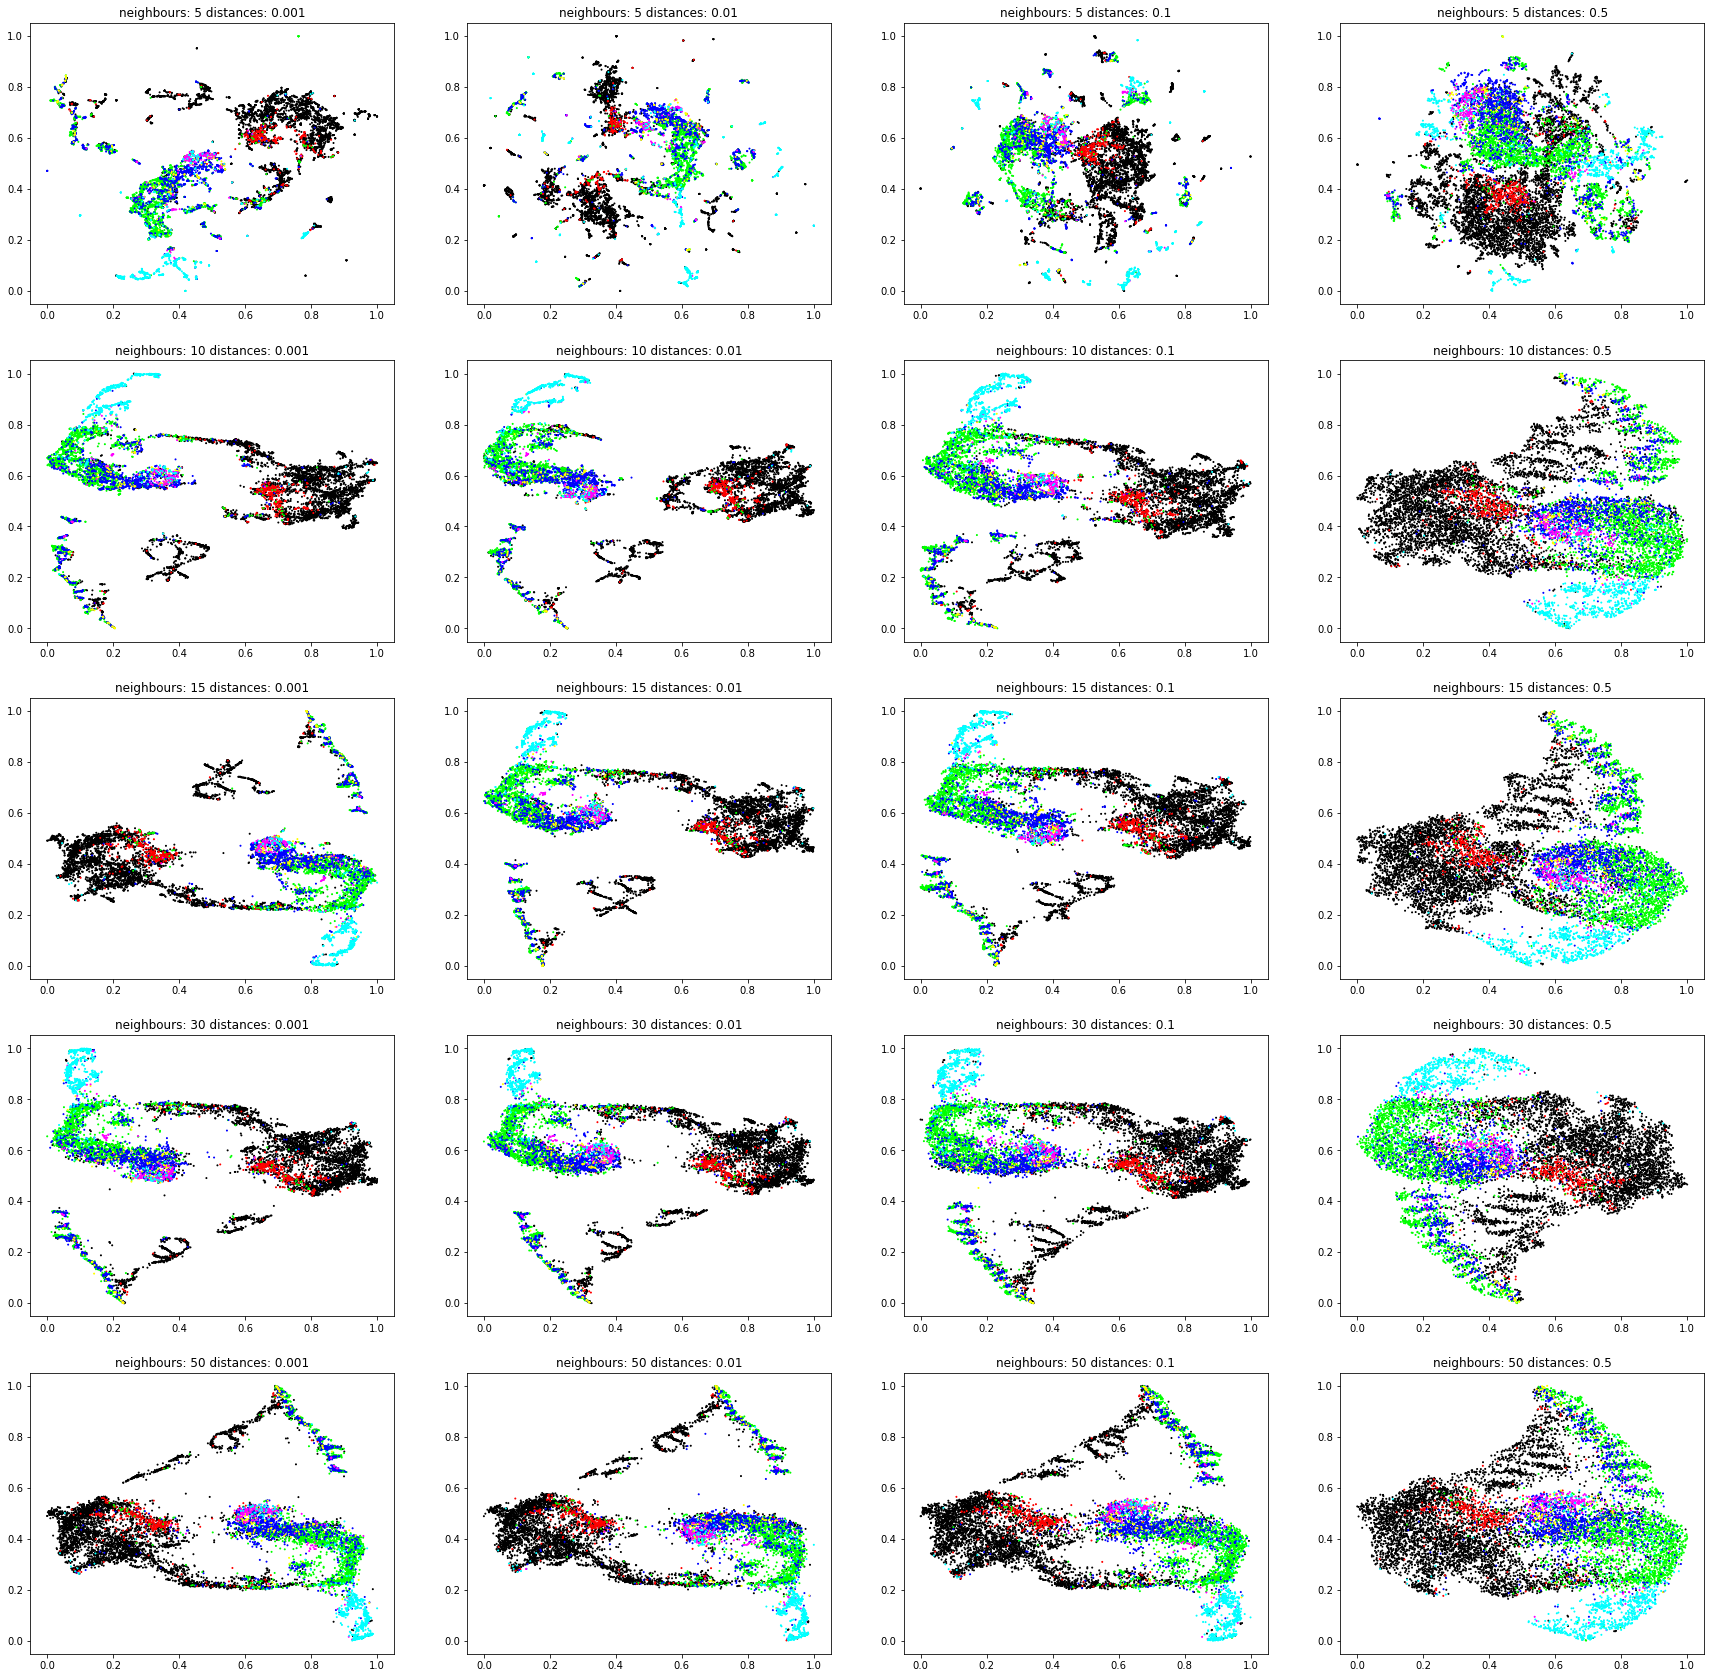

In [28]:
fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(distances) + j
        col.scatter(umap_embeddings['MIR'][current_plot].T[0], 
                    umap_embeddings['MIR'][current_plot].T[1], 
                    c=colorMap,
                    s=1)
        col.set_title("neighbours: " + str(neighbours[i]) + " distances: " + str(distances[j]))
plt.show()

In [29]:
umap_embeddings = {}
umap_embeddings['mfccs'] = []
umap_embeddings['MIR'] = []
umap_embeddings['STFT'] = []
umap_embeddings['Wavenet'] = []

neighbours = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        start_time = time.time()
        umap_mfccs = get_scaled_umap_embeddings(x_data_MFCC,
                                                neighbour,
                                                distance)
        umap_MIR = get_scaled_umap_embeddings(x_data_MIR,
                                                  neighbour,
                                                  distance)
        umap_STFT = get_scaled_umap_embeddings(x_data_STFT,
                                                  neighbour,
                                                  distance)
        umap_Wavenet = get_scaled_umap_embeddings(x_data_Wavenet,
                                                  neighbour,
                                                  distance)
        
        umap_embeddings['mfccs'].append(umap_mfccs)
        umap_embeddings['MIR'].append(umap_MIR)
        umap_embeddings['STFT'].append(umap_STFT)
        umap_embeddings['Wavenet'].append(umap_Wavenet)
        print("time in secs: ", time.time() - start_time, "neighbour: ",neighbour,"distance: ",distance)

time in secs:  53.55564904212952 neighbour:  5 distance:  0.0
time in secs:  52.734598875045776 neighbour:  5 distance:  0.001
time in secs:  52.90799021720886 neighbour:  5 distance:  0.01
time in secs:  53.098012924194336 neighbour:  5 distance:  0.1
time in secs:  52.42663502693176 neighbour:  5 distance:  0.5
time in secs:  60.154653787612915 neighbour:  10 distance:  0.0
time in secs:  59.26701998710632 neighbour:  10 distance:  0.001
time in secs:  58.698232889175415 neighbour:  10 distance:  0.01
time in secs:  59.13669991493225 neighbour:  10 distance:  0.1
time in secs:  60.63645815849304 neighbour:  10 distance:  0.5
time in secs:  74.73456311225891 neighbour:  15 distance:  0.0
time in secs:  80.22268915176392 neighbour:  15 distance:  0.001
time in secs:  83.21242475509644 neighbour:  15 distance:  0.01
time in secs:  89.71074414253235 neighbour:  15 distance:  0.1
time in secs:  91.3376772403717 neighbour:  15 distance:  0.5
time in secs:  129.50331497192383 neighbour:  30

In [30]:
# save UMAP embeddings that took so long to compute!
import pickle
with open('./drumEmbeddings/UMAP_embeddings_all.pkl','wb') as f:
    pickle.dump(umap_embeddings, f)

In [39]:
def plotEmbeddings(embedding,feature):
    fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(30, 30))

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            current_plot = i * len(distances) + j
            col.scatter(embedding[feature][current_plot].T[0], 
                        embedding[feature][current_plot].T[1], 
                        c=colorMap,
                        s=1)
            col.set_title("neighbours: " + str(neighbours[i]) + " distances: " + str(distances[j]))
plt.show()


from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point
def printMetricsUMAP(embeddings, labels):
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.001, 0.01, 0.1, 0.5]
    for i, neighbour in enumerate(neighbours):
        for j, distance in enumerate(distances):
            current_idx = i * len(distances) + j
            silhouette_avg = computeSilCoeff(embeddings[current_idx],labels)
            print(" -- neighbour:", neighbour, "distance:",distance," -- ")
            print("silhouette: ", silhouette_avg)
            
            '''
            geo_metrics = clusterGeometryMetrics(embeddings[current_idx],labels)
            roundness_mean = geo_metrics["roundness_mean"]
            overlap_ratio = geo_metrics["overlap_ratio"]
            print("roundness_mean", roundness_mean)
            print("overlap_ratio", overlap_ratio)
            
            aggregate = silhouette_avg + roundness_mean + overlap_ratio
            print("aggregate: ", aggregate)
            '''

In [32]:
import pickle
umap_embeddings = pickle.load(open('./drumEmbeddings/UMAP_embeddings_all.pkl', "rb"))

# Plotting UMAP on MIR

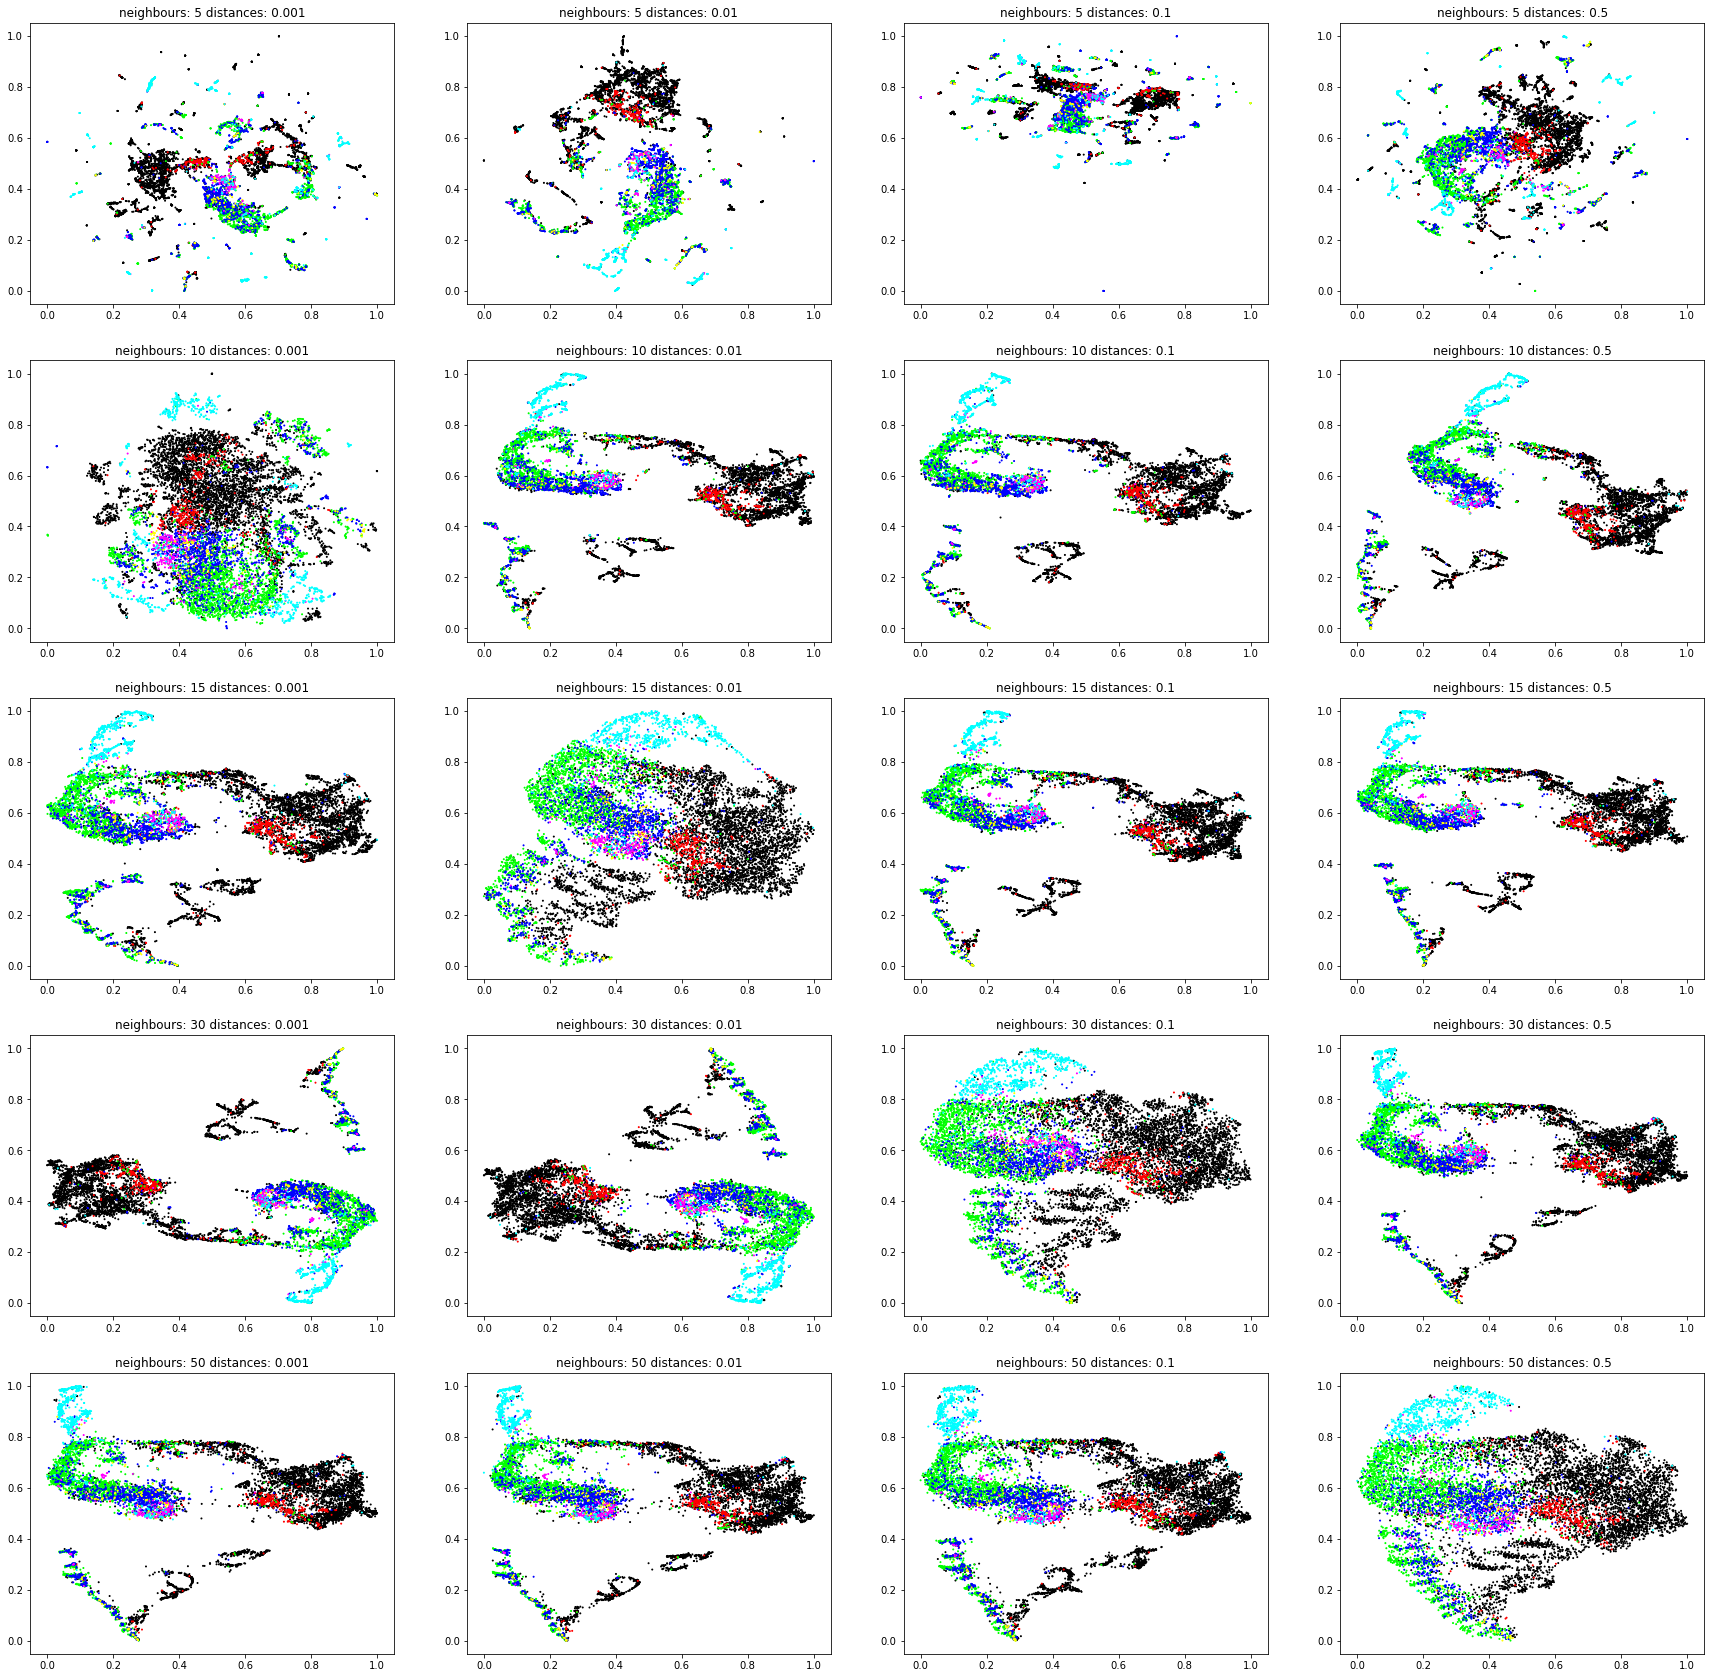

In [14]:
neighbours = [5, 10, 15, 30, 50]
distances = [0.001, 0.01, 0.1, 0.5]
plotEmbeddings(umap_embeddings,'MIR')

In [40]:
printMetricsUMAP(umap_embeddings['MIR'], y_data)

 -- neighbour: 5 distance: 0.001  -- 
silhouette:  -0.146833519867
 -- neighbour: 5 distance: 0.01  -- 
silhouette:  -0.104224601929
 -- neighbour: 5 distance: 0.1  -- 
silhouette:  -0.170812541871
 -- neighbour: 5 distance: 0.5  -- 
silhouette:  -0.125621547854
 -- neighbour: 10 distance: 0.001  -- 
silhouette:  -0.133115326734
 -- neighbour: 10 distance: 0.01  -- 
silhouette:  -0.0862583823656
 -- neighbour: 10 distance: 0.1  -- 
silhouette:  -0.0950159898034
 -- neighbour: 10 distance: 0.5  -- 
silhouette:  -0.111931322224
 -- neighbour: 15 distance: 0.001  -- 
silhouette:  -0.085495055232
 -- neighbour: 15 distance: 0.01  -- 
silhouette:  -0.0944814463386
 -- neighbour: 15 distance: 0.1  -- 
silhouette:  -0.102775891526
 -- neighbour: 15 distance: 0.5  -- 
silhouette:  -0.0948585676528
 -- neighbour: 30 distance: 0.001  -- 
silhouette:  -0.0947961978354
 -- neighbour: 30 distance: 0.01  -- 
silhouette:  -0.08993463319
 -- neighbour: 30 distance: 0.1  -- 
silhouette:  -0.08481017310

# Plotting UMAP on MFCC

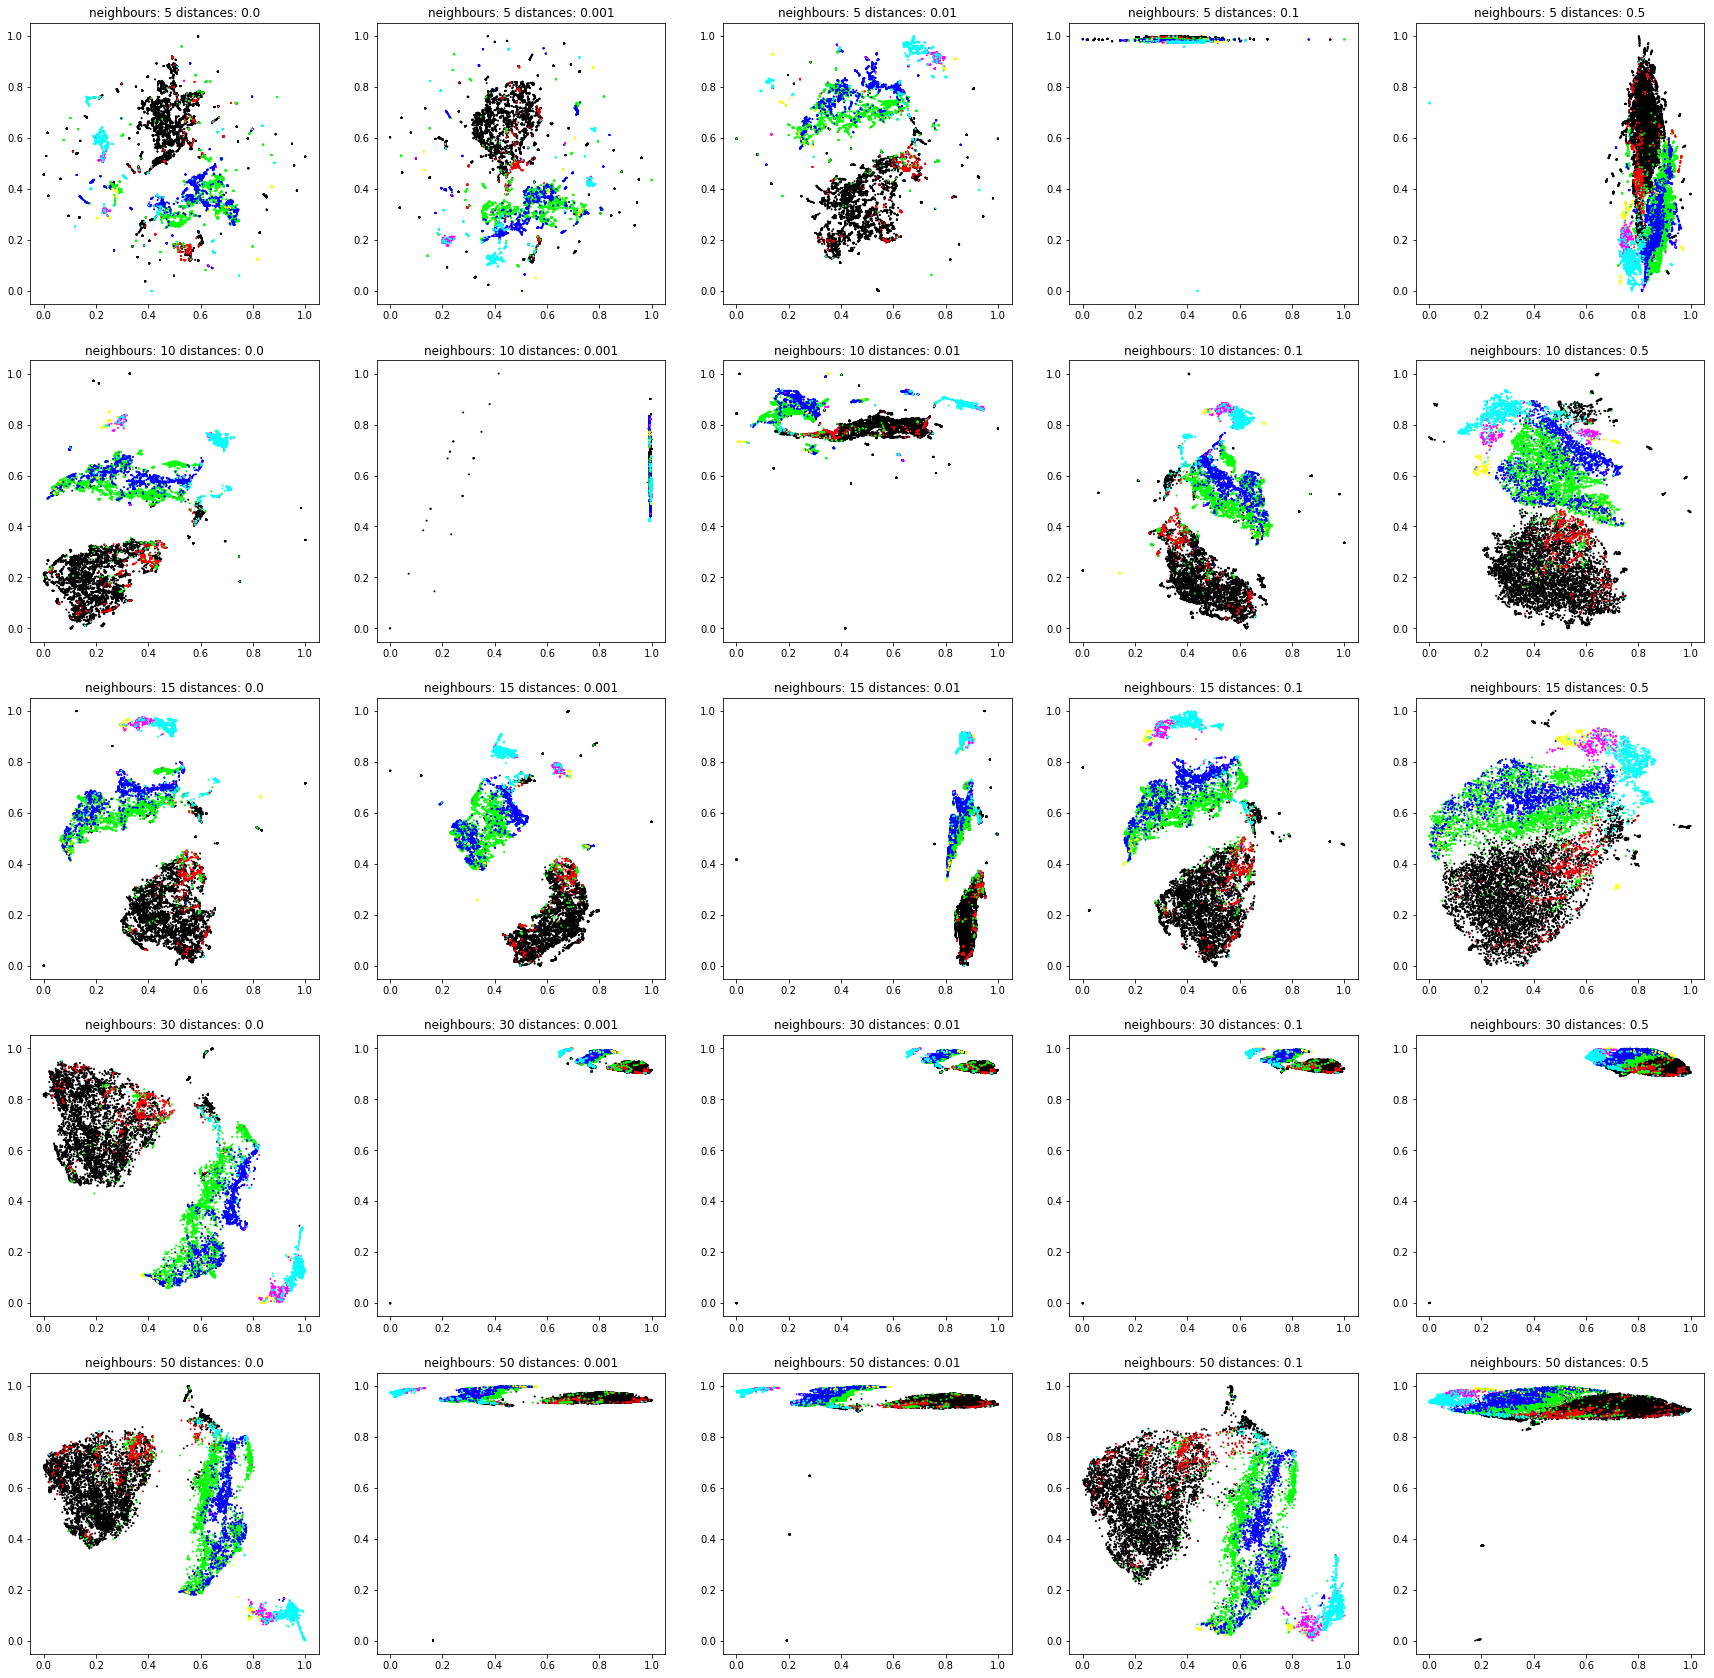

In [34]:
plotEmbeddings(umap_embeddings,'mfccs')

# Plotting UMAP on STFT

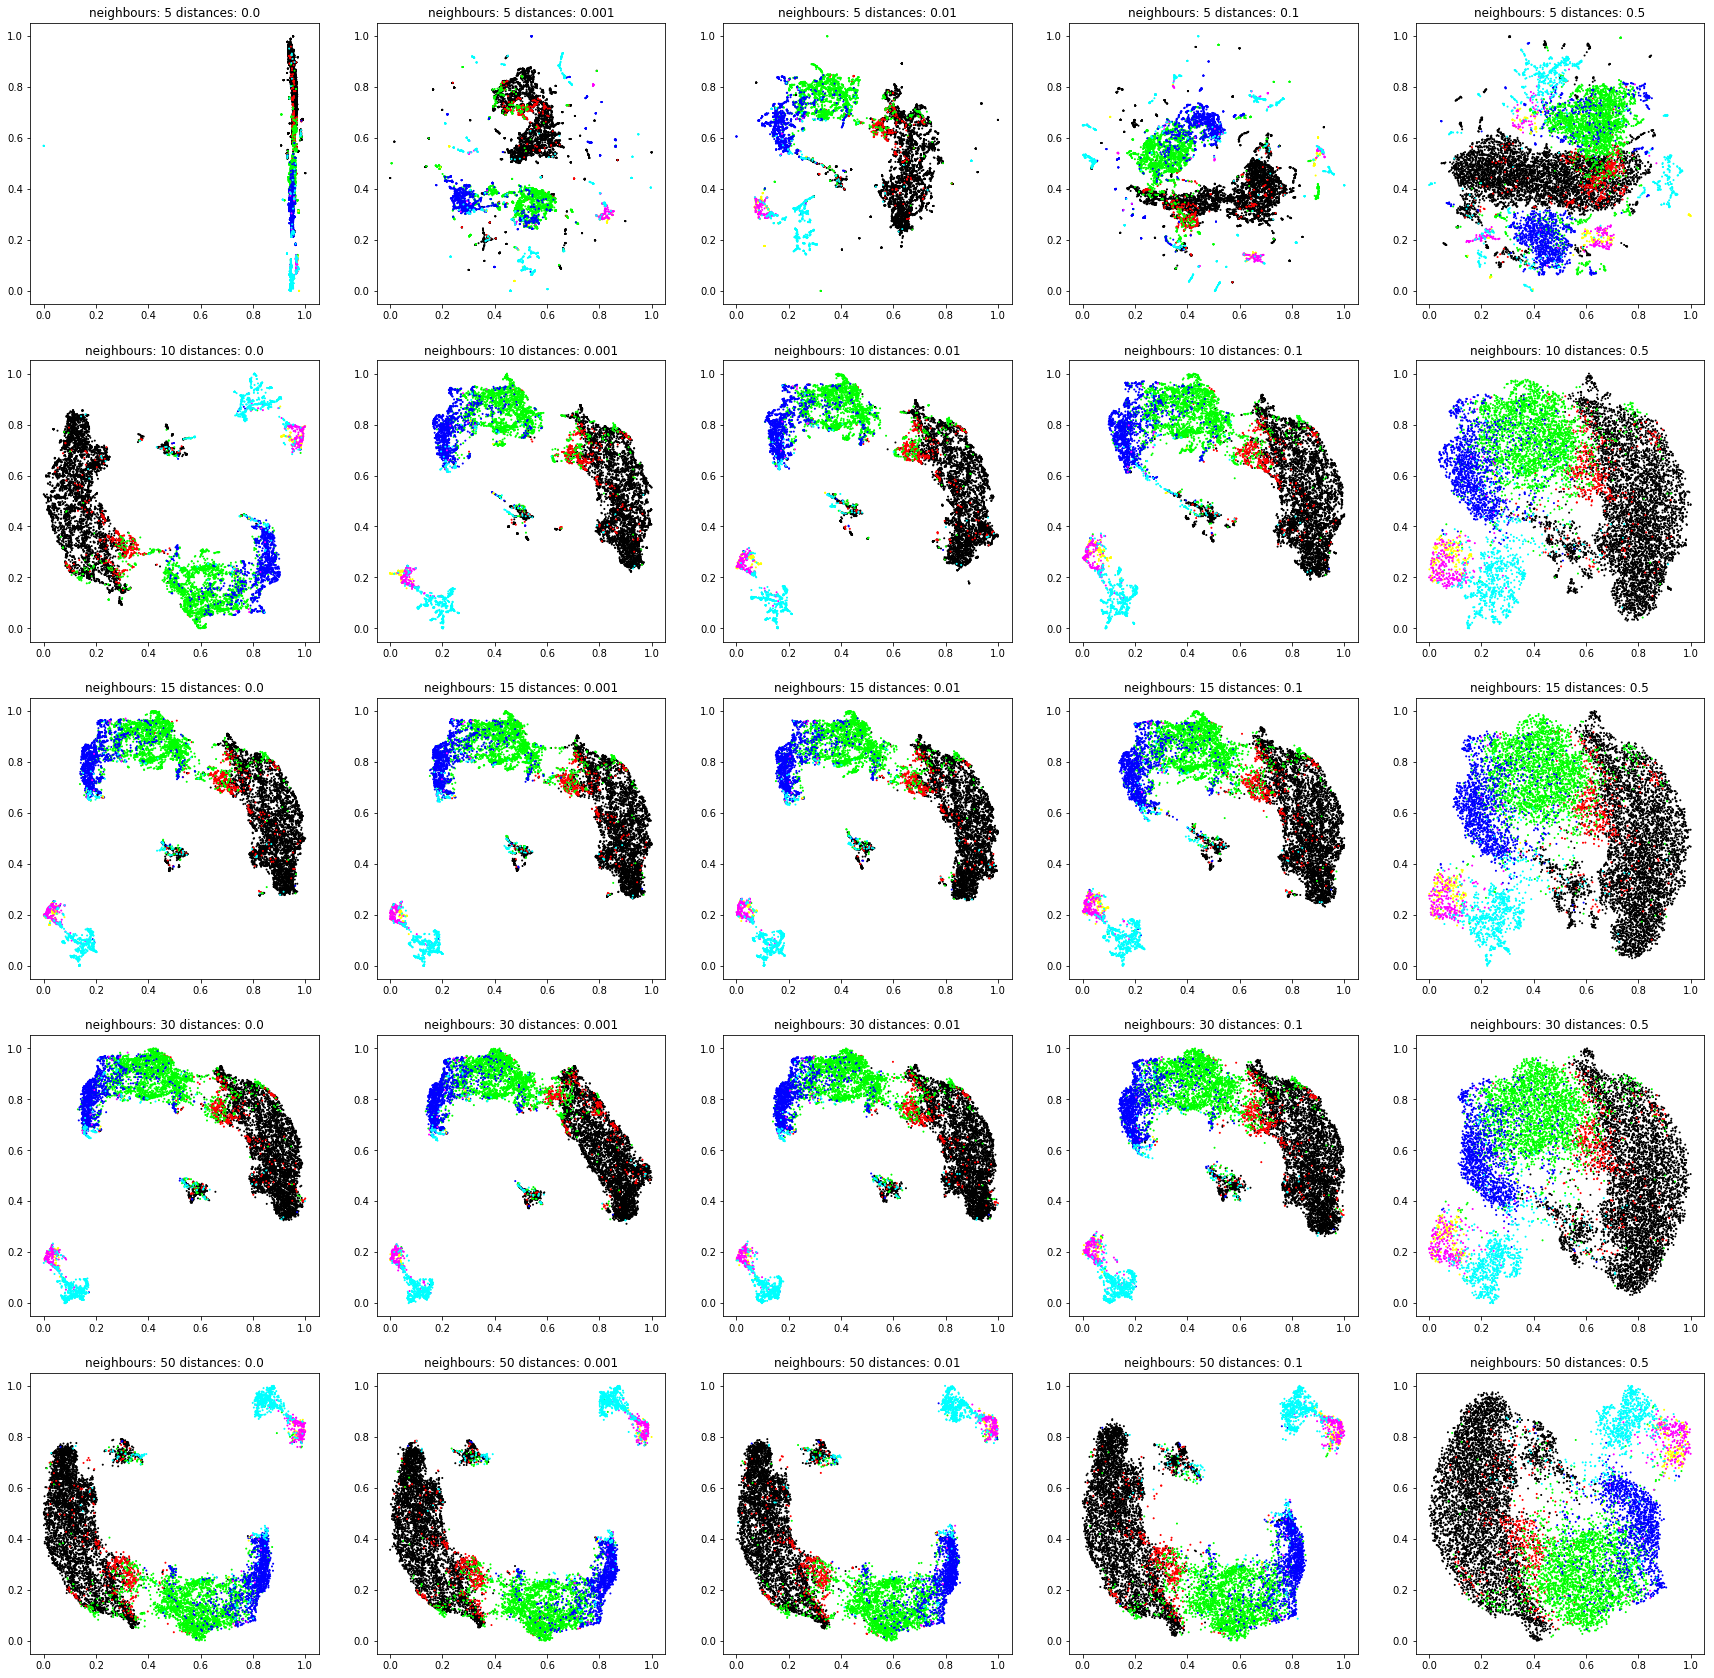

In [36]:
plotEmbeddings(umap_embeddings,'STFT')

# Plotting UMAP on WaveNet

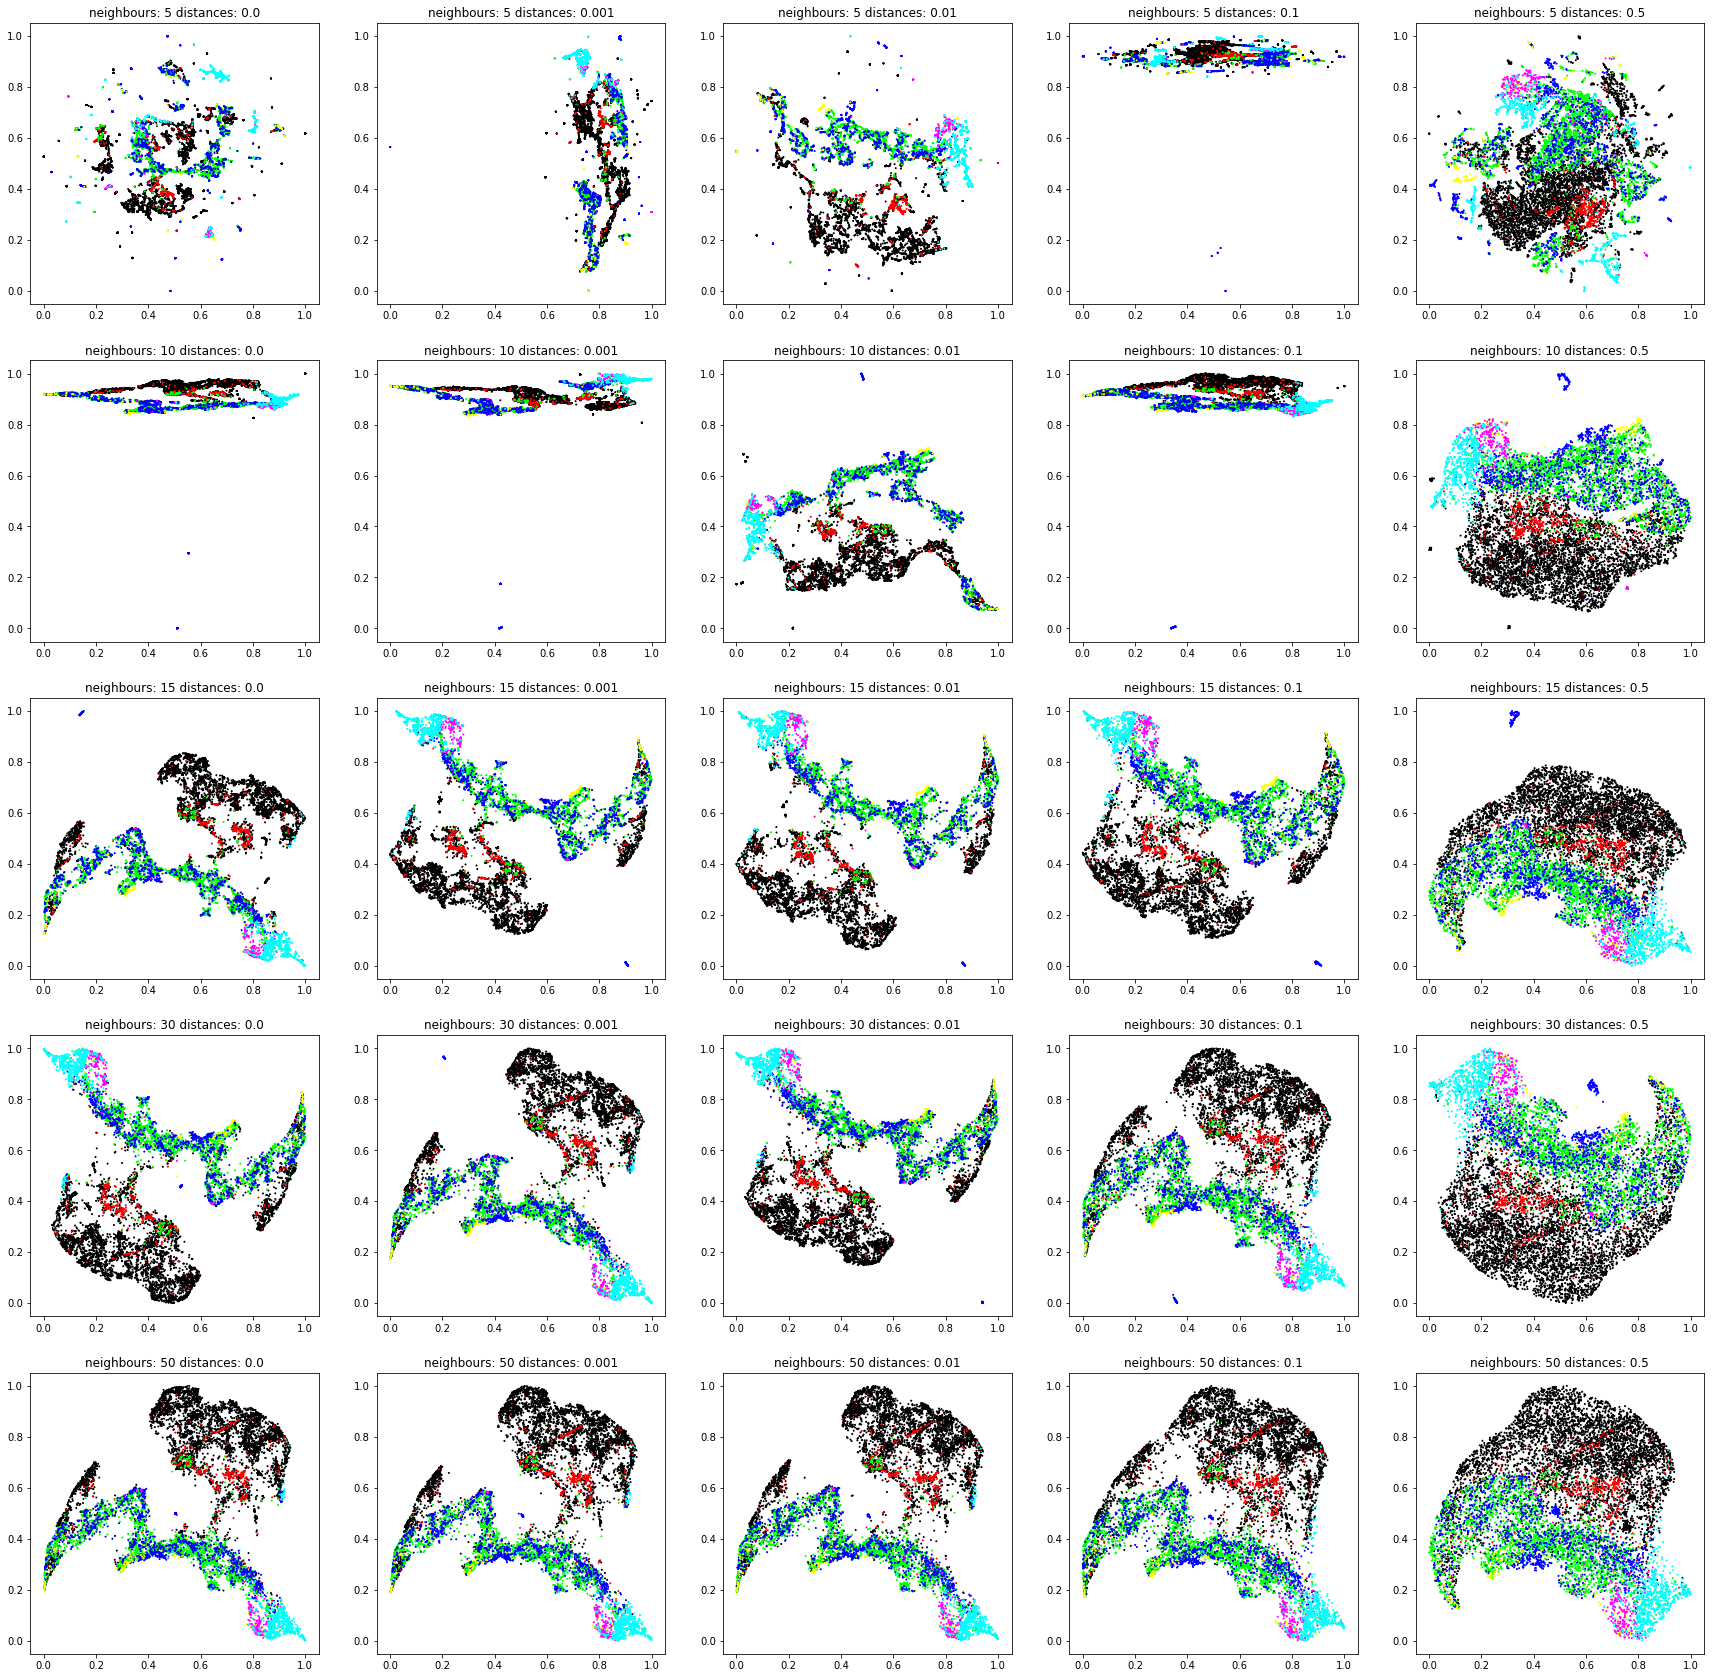

In [38]:
plotEmbeddings(umap_embeddings,'Wavenet')